In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# ---------------------------
# 1. Connect to Database & Load OECD Data (EPEA_GDP)
# ---------------------------
conn = sqlite3.connect("global_energy.db")

# Query the 'EPEA_GDP' measure from OECD data
df_oecd = pd.read_sql_query("""
    SELECT country, TIME_PERIOD AS year, OBS_VALUE AS env_tax
    FROM oecd_greengrowth
    WHERE MEASURE = 'EPEA_GDP'
    """, conn)

print(f"OECD data has {len(df_oecd)} rows for 'EPEA_GDP'.")
print(df_oecd.head())

# Handle any duplicates by grouping on (country, year) and taking median
df_oecd_clean = df_oecd.groupby(['country', 'year'], as_index=False).median()

# Convert year to numeric
df_oecd_clean["year"] = pd.to_numeric(df_oecd_clean["year"], errors="coerce").astype("Int64")


OECD data has 354 rows for 'EPEA_GDP'.
   country  year  env_tax
0  Türkiye  2013     1.16
1  Türkiye  2014     1.18
2  Türkiye  2015     1.08
3  Türkiye  2016     1.04
4  Türkiye  2017     1.09


In [3]:
# ---------------------------
# 2. Load & Merge Power Plant / World Bank Data (Year = 2015)
# ---------------------------
# 2.1: country_capacity for renewable ratio
df_capacity = pd.read_sql_query("SELECT * FROM country_capacity;", conn)
df_capacity["renewable_ratio"] = df_capacity["total_renewable_capacity"] / df_capacity["total_capacity"]

# 2.2: World Bank - Energy use (kg of oil eq. per capita) in 2015
df_energy = pd.read_sql_query("""
    SELECT country, "2015 [YR2015]" AS energy_use_2015
    FROM world_bank
    WHERE [Series Name] = 'Energy use (kg of oil equivalent per capita)'
    """, conn)

# 2.3: World Bank - GDP (current US$) in 2015
df_gdp = pd.read_sql_query("""
    SELECT country, "2015 [YR2015]" AS gdp_2015
    FROM world_bank
    WHERE [Series Name] = 'GDP (current US$)'
    """, conn)

# Merge capacity, energy use, and GDP data
df_cluster = pd.merge(df_capacity, df_energy, on="country", how="inner")
df_cluster = pd.merge(df_cluster, df_gdp, on="country", how="inner")

# 2.4: Filter the OECD data for year=2015
df_oecd_2015 = df_oecd_clean[df_oecd_clean["year"] == 2015].copy()

# Merge the OECD 2015 data (env_tax) with the cluster DataFrame
df_cluster = pd.merge(df_cluster, df_oecd_2015, on="country", how="left")

# Rename columns for clarity
df_cluster.rename(columns={"env_tax": "env_policy_2015"}, inplace=True)

# Fill missing env_policy_2015 with 0 or another fallback
df_cluster["env_policy_2015"] = df_cluster["env_policy_2015"].fillna(0)

In [4]:
# ---------------------------
# 3. Clean & Prepare for Clustering
# ---------------------------
# Convert possible string placeholders (e.g., "..") to numeric
df_cluster["energy_use_2015"] = pd.to_numeric(df_cluster["energy_use_2015"], errors="coerce")
df_cluster["gdp_2015"] = pd.to_numeric(df_cluster["gdp_2015"], errors="coerce")
df_cluster["renewable_ratio"] = pd.to_numeric(df_cluster["renewable_ratio"], errors="coerce")
df_cluster["env_policy_2015"] = pd.to_numeric(df_cluster["env_policy_2015"], errors="coerce")

# Drop rows with NaN in any of the key columns
df_cluster.dropna(subset=["renewable_ratio", "energy_use_2015", "gdp_2015", "env_policy_2015"], inplace=True)


=== Cluster Profiling ===
   cluster  renewable_ratio  energy_use_2015      gdp_2015  env_policy_2015
0        0         0.243595      3172.357224  3.493102e+11         1.746429
1        1         0.791230      6721.326256  4.719655e+11         1.132500
2        2         0.270147      3316.493254  2.521273e+12         0.951429


/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/1456250287.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x="cluster", y=metric, palette="viridis")


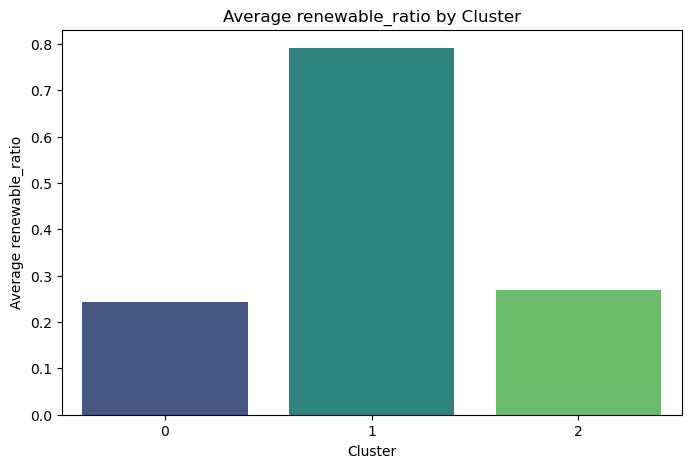

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/1456250287.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x="cluster", y=metric, palette="viridis")


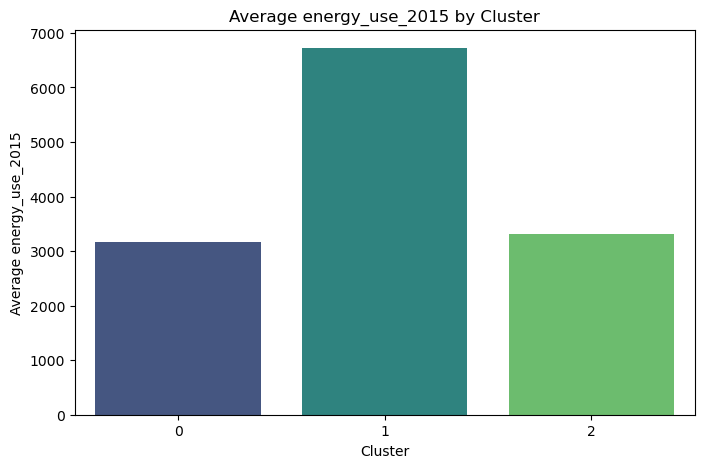

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/1456250287.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x="cluster", y=metric, palette="viridis")


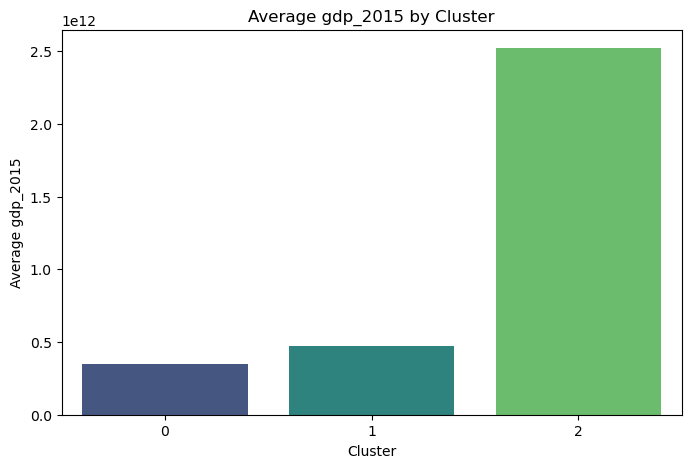

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/1456250287.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x="cluster", y=metric, palette="viridis")


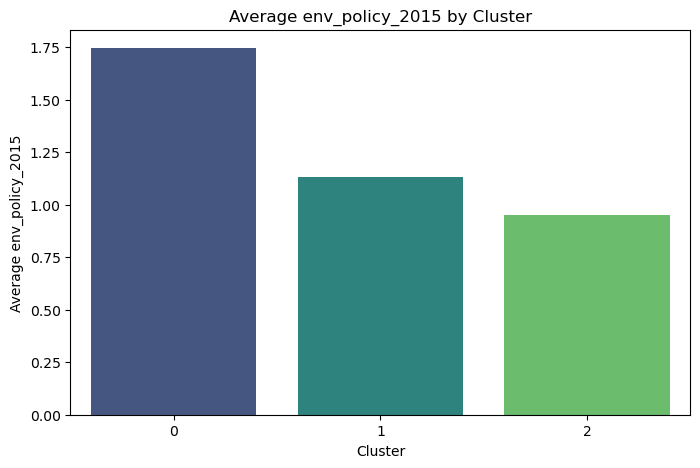

In [5]:
# ---------------------------
# 4. Clustering Analysis & Profiling
# ---------------------------
# Prepare features
features = df_cluster[["renewable_ratio", "energy_use_2015", "gdp_2015", "env_policy_2015"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(features_scaled)

# Cluster Profiling
cluster_profile = df_cluster.groupby("cluster")[
    ["renewable_ratio", "energy_use_2015", "gdp_2015", "env_policy_2015"]
].mean().reset_index()

print("\n=== Cluster Profiling ===")
print(cluster_profile)

# Visualize each metric
metrics = ["renewable_ratio", "energy_use_2015", "gdp_2015", "env_policy_2015"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=cluster_profile, x="cluster", y=metric, palette="viridis")
    plt.title(f"Average {metric} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(f"Average {metric}")
    plt.show()

In [6]:
# ---------------------------
# 5. Enhanced Geospatial Analysis
# ---------------------------
df_power = pd.read_csv("Data/global_power_plant_database.csv")

fuel_types = ["coal", "solar", "wind"]

def plot_density_map(fuel):
    df_fuel = df_power[df_power["primary_fuel"].str.contains(fuel, case=False, na=False)]
    fig = px.density_mapbox(
        df_fuel,
        lat="latitude",
        lon="longitude",
        z="capacity_mw",
        radius=10,
        center=dict(lat=20, lon=0),
        zoom=0,
        mapbox_style="stamen-terrain",
        title=f"Density Map of {fuel.title()} Power Plants"
    )
    fig.show()

for fuel in fuel_types:
    plot_density_map(fuel)

# Close DB connection
conn.close()

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/7061351.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_power = pd.read_csv("Data/global_power_plant_database.csv")
/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/7061351.py:10: DeprecationWarning: *density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.density_mapbox(


/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_4505/7061351.py:10: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

